In [1]:
# install skforecast
# **************************************************************************************************************
!pip install skforecast -q

# Libraries

In [2]:
# standard libraries
# **************************************************************************************************************
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings, gc
warnings.simplefilter('ignore')

# visualisation
# **************************************************************************************************************
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1

# sklearn
# **************************************************************************************************************
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.impute import *

# skforecast
# **************************************************************************************************************
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster


# Data Load

In [3]:
# data load
# **************************************************************************************************************
CSV = '/kaggle/input/tsla-stock-data/tsla_split_adjusted.csv'
df = pd.read_csv(CSV, parse_dates=['date'])


# formating the float
# **************************************************************************************************************
float_cols = df.select_dtypes(np.float64).columns
for c in float_cols:
    df[c] = df[c].apply(lambda x: np.round(x,3))


# data sampling
# **************************************************************************************************************
'''sampling the data for last n years'''
n = 3
end_year = df['date'].dt.year.max()
start_year = end_year - n

df = df.loc[(df['date'].dt.year >= start_year)
                     & (df['date'].dt.year <= end_year)]


# set index
# **************************************************************************************************************
df.set_index('date', inplace=True)


# filtering columns
# **************************************************************************************************************
wanted = ['open', 'high', 'low' , 'close']
df = df[wanted]


# set frequency
# **************************************************************************************************************
'''Pandas fills the gaps that may exist in the time series 
   with the value of NULL. Here the frequency is set to business days'''
df = df.asfreq('B',method='ffill')


# view
# **************************************************************************************************************
df.head()

,open,high,low,close
date,,,,
2020-01-02,28.300,28.713,28.114,28.684
2020-01-03,29.367,30.267,29.128,29.534
2020-01-06,29.365,30.104,29.333,30.103
2020-01-07,30.760,31.442,30.224,31.271
2020-01-08,31.580,33.233,31.215,32.809


## Train & Test Split

Train dates : 2020-01-02 00:00:00 --- 2022-11-08 00:00:00  (n=744)
Test dates  : 2022-11-09 00:00:00 --- 2023-08-15 00:00:00  (n=200)



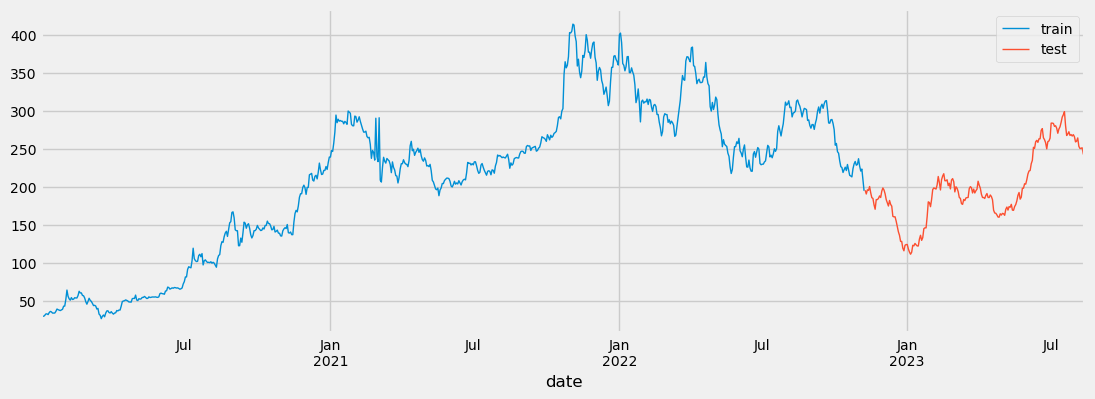

In [4]:
# train & test data split
# **************************************************************************************************************
size = 200  # last n days
data_train = df[:-size]
data_test  = df[-size:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
print()


# plot the training & validation data
# **************************************************************************************************************

col = 'high'
fig, ax = plt.subplots(figsize=(12, 4))
data_train[col].plot(ax=ax, label='train')
data_test[col].plot(ax=ax, label='test')
ax.legend();

# Recursive Autoregressive Forecasting

<br>

## ForecasterAutoreg

<p><strong> 
    With this class, a model is created and trained from "RandomForestRegressor" with a time window of n lags. This means that the model uses the previous n days as predictors
</strong></p>

In [5]:
# Create and train forecasterAutoreg
# **************************************************************************************************************
n_days = 120
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(criterion = 'absolute_error', random_state= np.random.randint(100)),
                lags      = n_days)

forecaster.fit(y=data_train[col])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(criterion='absolute_error', random_state=70) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] 
Transformer for y: None 
Transformer for exog: None 
Window size: 120 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-01-02 00:00:00'), Timestamp('2022-11-08 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: B 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0

## Prediction

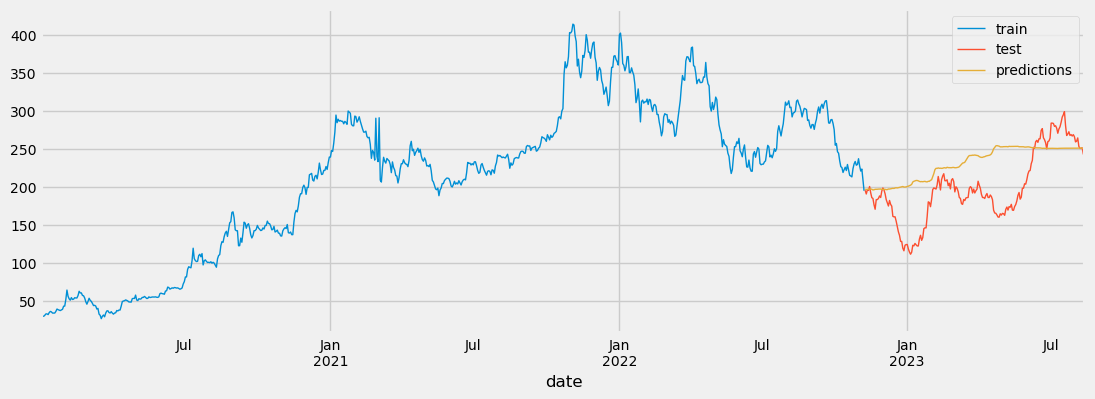

In [6]:
# future prediction
# **************************************************************************************************************
'''once trained, the model predicts n days in future'''
n_future_days = 200 
preds = forecaster.predict(steps=n_future_days)


# plot the predicted data
# **************************************************************************************************************
fig, ax = plt.subplots(figsize=(12, 4))
data_train[col].plot(ax=ax, label='train')
data_test[col].plot(ax=ax, label='test')
preds.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Test error
# **************************************************************************************************************
'''The error that the model makes in its predictions is quantified. 
    The metric used is the mean absolute error (mae)'''

error = mean_absolute_error(
                y_true = data_test[col],
                y_pred = preds
            )

print(f"Mean Absolute Error: {'{:.3f}'.format(error)}")

Mean Absolute Error: 39.771


# Hyperparameter Tuning

<p><strong> 
   Skforecast library provides the grid_search_forecaster function. It compares the results obtained with multiple combinations of hyperparameters and lags, and identify the best one
</strong></p>

In [8]:
# hyperparameter grid search
# **************************************************************************************************************
forecaster_tune = ForecasterAutoreg(
                regressor = RandomForestRegressor(criterion = 'absolute_error', random_state= np.random.randint(100)),
                lags      = n_days # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [150, 180, 200]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster_tune,
                        y                  = data_train[col],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = n_future_days,
                        refit              = False,
                        metric             = 'mean_absolute_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
               )

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 66.83500265053785



# Final Model

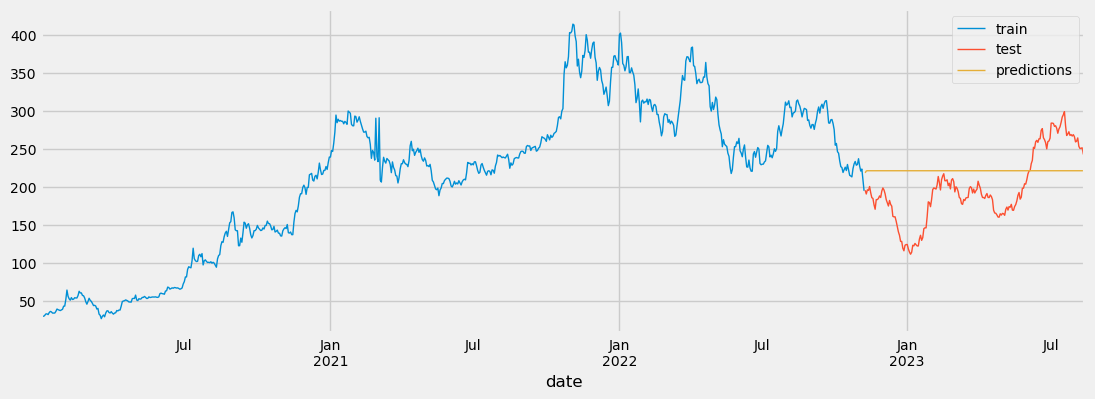

In [9]:
# create regressor and train the forecaster with the best hyperparameters
# **************************************************************************************************************
regressor_tune = RandomForestRegressor(max_depth=3, n_estimators=100, criterion = 'absolute_error', random_state= np.random.randint(100))
forecaster_opt = ForecasterAutoreg(
                regressor = regressor_tune,
                lags      = 200)

forecaster_opt.fit(y=data_train[col])


# predictions with new & optimized forecaster
# **************************************************************************************************************
preds_opt = forecaster_opt.predict(steps=n_future_days)


# plot the new predicted data
# **************************************************************************************************************
fig, ax = plt.subplots(figsize=(12, 4))
data_train[col].plot(ax=ax, label='train')
data_test[col].plot(ax=ax, label='test')
preds_opt.plot(ax=ax, label='predictions')
ax.legend();

<p><strong>
    It looks like the hyperparameter tuning hasn't worked. Well, we can always go back to the original model
</strong></p>